# Bài toán dự đoán khả năng sống sót trên tàu khi đi du lịch

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline
pd.set_option('display.max_columns', None)

In [3]:
# #warning
import warnings
warnings.filterwarnings('ignore')
# load 2 number after point
pd.options.display.float_format = "{:.2f}".format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [178]:
def missing_exploration(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

Import Data

In [4]:
data = pd.read_csv('train.csv',index_col = 'PassengerId' )

Khảo sát tổng quan dữ liệu (Thông tin dữ liệu: 1.1 Khảo sát kích thước dữ liệu. 1.2 Tìm hiểu ý nghĩa thực tế từng feature, kiểu dữ liệu của nó.

In [5]:
print(data.shape)
data.head(10)

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.46,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.86,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.07,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.13,NaN,S


In [57]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [6]:
data.drop(columns = ['Name'], axis = 1, inplace = True)
data.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,male,22.00,1,0,A/5 21171,7.25,NaN,S
2,1,1,female,38.00,1,0,PC 17599,71.28,C85,C
3,1,3,female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S


In [85]:
data['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [86]:
data['SibSp'].unique()
# SibSp bị outlier 1 cái fill bằng 8

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [73]:
data[data['SibSp'] == 8]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


Dữ liệu Missing

In [7]:
missing_exploration(data)

,Total,Percent
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Pclass,0,0.00
Survived,0,0.00


1. Cabin missing đến 77% dữ liệu, độ missing quá cao --> bỏ

In [9]:
data['Fare'].nunique()
data['Ticket'].nunique()
data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [45]:
print(data.info())
data.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB
None


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,714.00,891.00,891.00,891.00
mean,0.38,2.31,29.70,0.52,0.38,32.20
std,0.49,0.84,14.53,1.10,0.81,49.69
min,0.00,1.00,0.42,0.00,0.00,0.00
25%,0.00,2.00,20.12,0.00,0.00,7.91
50%,0.00,3.00,28.00,0.00,0.00,14.45
75%,1.00,3.00,38.00,1.00,0.00,31.00
max,1.00,3.00,80.00,8.00,6.00,512.33


3. Tương quan dữ liệu
Nhắm tìm ra các thuộc tính ảnh hưởng với target nhiều nhất và tiến hành khảo sát (correlation Matrix )

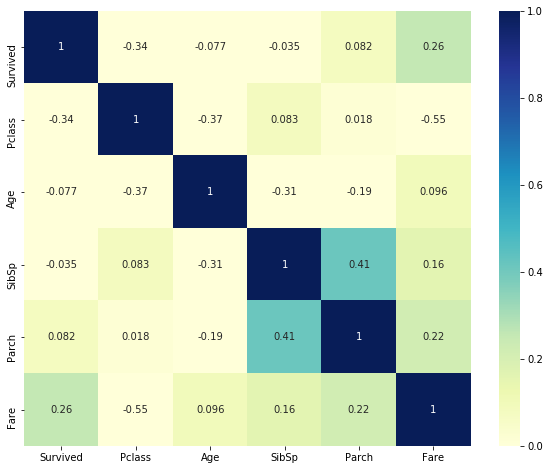

In [6]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat,cmap = "YlGnBu", annot = True,vmin=0, vmax=1)
#sns.heatmap(corrmat, cmap = 'YlGnBu', vmax=1.0, square=True)

In [7]:
categorical = ['Survived','Pclass', 'SibSp', 'Parch','Sex','Embarked']
numerical = ['Age',  'Fare']

In [8]:
data[categorical] = data[categorical].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null object
Pclass      891 non-null object
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null object
Parch       891 non-null object
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    891 non-null object
dtypes: float64(2), object(9)
memory usage: 83.5+ KB


II. Khảo sát chi tiết

# 1-D Exploration

# Analyzing Categorical Variables

Khao sat tong quan du lieu category

In [9]:
data[categorical].describe(include = 'all')

,Survived,Pclass,SibSp,Parch,Sex,Embarked
count,891,891,891,891,891,891
unique,2,3,7,7,2,4
top,0,3,0,0,male,S
freq,549,491,608,678,577,644


Ket luan

In [ ]:
2.2 Khảo sát phân bổ data với các giá trị phân loại (countplot, barplot, pieplot)

0    549
1    342
Name: Survived, dtype: int64


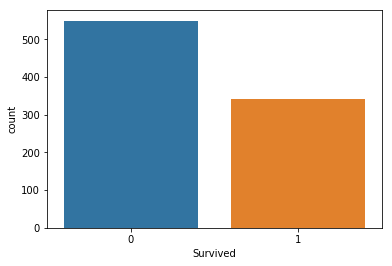

In [99]:
sns.countplot(data['Survived'])
print(data["Survived"].value_counts())

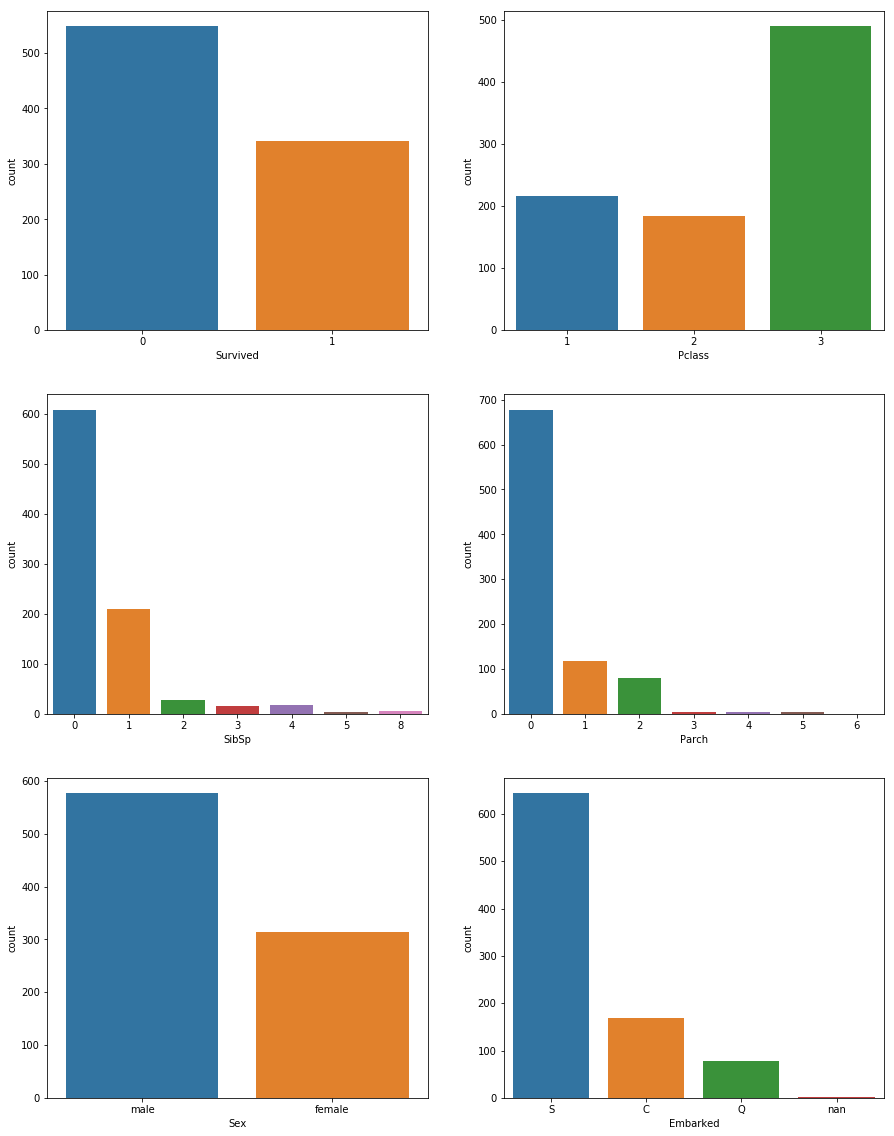

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(15, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.countplot(data[var], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

Kết luận:
1. Survival: Có sự chênh lệnh giữa số lượng tử vong và sống sót (tử vong 548/891tổng số dữ liệu khảo sát).
1. Pclass: Phần lớn khách hàng chọn ghế hạng thấp nhất (hạng 3) - gần 500 khách hàng, chiếm khoảng 55%
           Còn lại 45% Khách hàng chọn ghế hạng (1 và hạng 2) - với tỉ lệ chệnh lệch không cao
2. Sex: Phần lớn khách hàng là Nam giới : 577 khách hàng (chiếm khoảng 70%), nữ giới: khoảng 300 KH, chiếm khoảng 30%
3. SibSp and Parch: phần lớn các khách hàng đi một mình (không đi cùng vợ chồng, cha mẹ, con cái,..)
5. Embarked: Phần lớn hành khách lên tàu từ cảng S( Southampton)

order = housing['SaleCondition'].value_counts().index
data[numerical].describe(percentiles=[0.05*i for i in range(20)] + [0.99])

# Analyzing Numerical Variables

In [13]:
data[numerical].describe()

,Age,Fare
count,714.00,891.00
mean,29.70,32.20
std,14.53,49.69
min,0.42,0.00
25%,20.12,7.91
50%,28.00,14.45
75%,38.00,31.00
max,80.00,512.33


In [137]:
data[numerical].describe(percentiles=[0.02*i for i in range(50)] + [0.99])

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
0%,0.420000,0.000000
2%,2.000000,6.397500
4%,3.000000,7.052520
6%,5.000000,7.225000
8%,9.000000,7.250000
10%,14.000000,7.550000


1.2 Khảo sát hình thái phân phối data bằng histogram

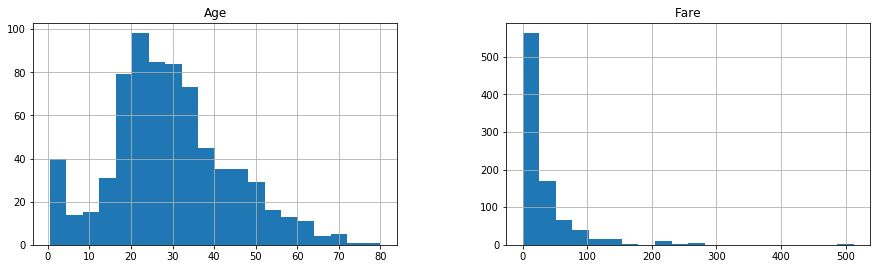

In [14]:
data[numerical].hist(bins=20, figsize=(15, 20), layout=(4, 2));

1.3 Khảo sát sự phân bổ data bằng boxplot

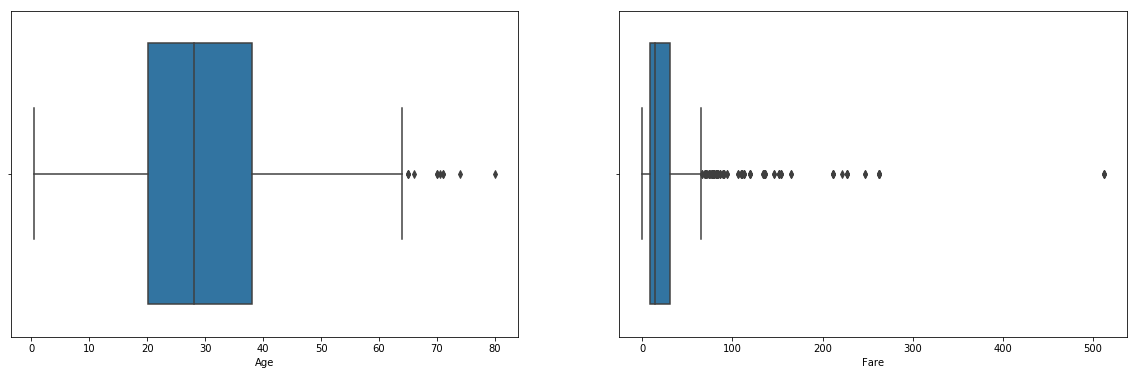

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
for i, subplot in zip(numerical, ax.flatten()):
    sns.boxplot(data[i], ax=subplot)

1.4 Khảo sát độ nhọn, độ lệch của data

In [131]:
print("Skewness of Age: %f" % data['Age'].skew())
print("Kurtosis of Age: %f" % data['Age'].kurt())
print("Skewness of Fare: %f" % data['Fare'].skew())
print("Kurtosis of Fare: %f" % data['Fare'].kurt())

Skewness of Age: 0.389108
Kurtosis of Age: 0.178274
Skewness of Fare: 4.787317
Kurtosis of Fare: 33.398141


1.5 Kết luận

1.Age
    - Phần lớn hành khách nằm trong độ tuổi thanh niên: từ 18 -> 40 tuổi, chỉ có 1 vài hành khách ở độ tuổi từ 65 -> 80 tuổi
    - Age phân phối theo dạng Normal Distribution, có xu hướng lệch phải, hơi nhọn
   
2. Fare
    - Hành khách có xu hướng chọn các loại vé rẻ.Phần lớn khách hàng chọn các loại vé có giá từ 8 đến 30, một số ít khách hàng chọn các vé có giá từ 30 đến 160,
    có một vài khách hàng hạng sang chọn loại vé có giá từ 210 đến 260 và  rất ít khách hàng chọn vé có giá 480 đến 510
    - Fare phân bố lệch mạnh về phía phải và rất nhọn    

# 2-D Exploration

# 2. 1Khảo sát sự phụ thuộc của Survived với các biến categorical

2.1 Khảo sát tổng quan về data của biến (describe)
số lượng giá trị phân loại (value_counts)

In [167]:
data[categorical].describe(include = 'all')

,Survived,Pclass,Sex,SibSp,Parch,Embarked
count,891,891,891,891,891,891
unique,2,3,2,7,7,4
top,0,3,male,0,0,S
freq,549,491,577,608,678,644


2.2 Khảo sát phân bổ data với các giá trị phân loại (countplot, barplot, pieplot)

0.0


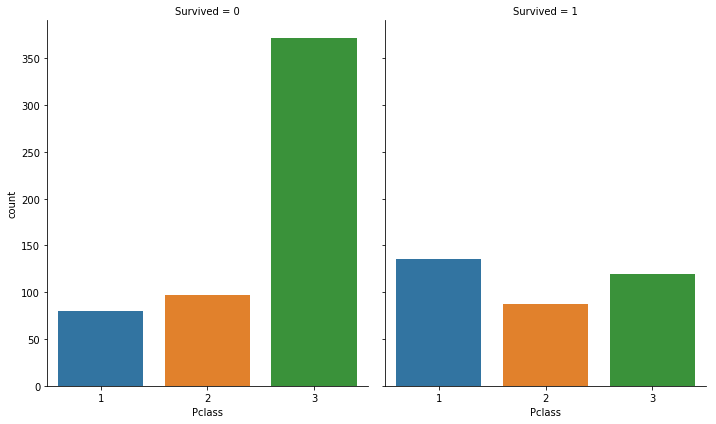

In [170]:
sns.catplot("Pclass", col="Survived", col_wrap=4,
               data=data[data.Survived.notnull()],
                kind="count", height=6, aspect=.8)


Kết luận: Pclass càng cao thì tỉ lệ tử vong càng cao, cụ thể:
        - Pclass = 3, tỉ lệ tử vong/ tỉ lệ sống sót gần bằng 3, trong khi đó tỉ lệ này ngang nhau khi Pclass = 2 và khi Pclass =1
        thì tỉ lệ này chỉ còn khoảng 2/3

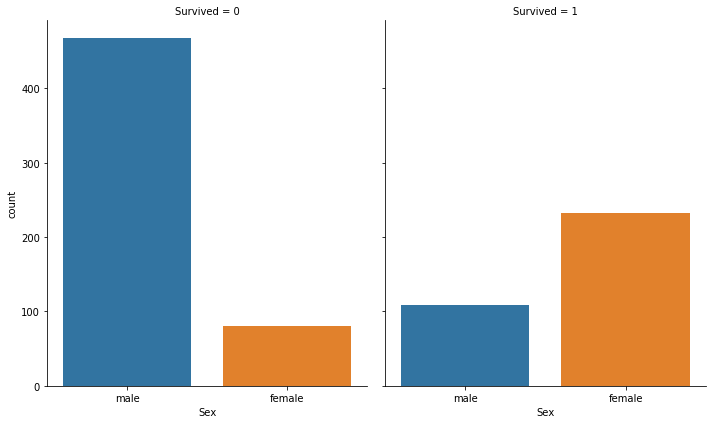

In [161]:
sns.catplot("Sex", col="Survived", col_wrap=4,
               data=data[data.Survived.notnull()],
                kind="count", height=6, aspect=.8)

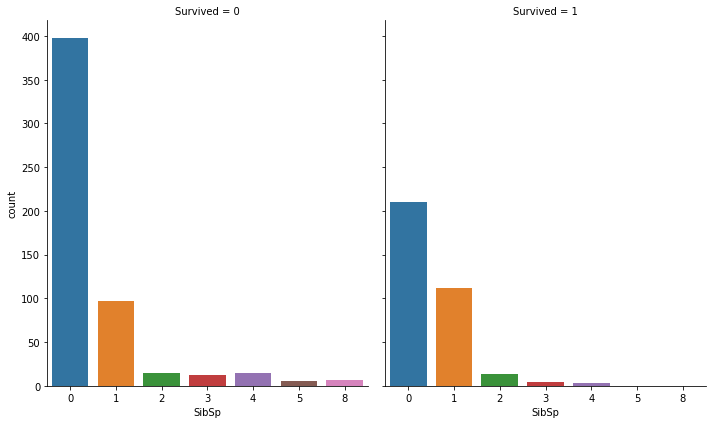

In [162]:
sns.catplot("SibSp", col="Survived", col_wrap=4,
               data=data[data.Survived.notnull()],
                kind="count", height=6, aspect=.8)

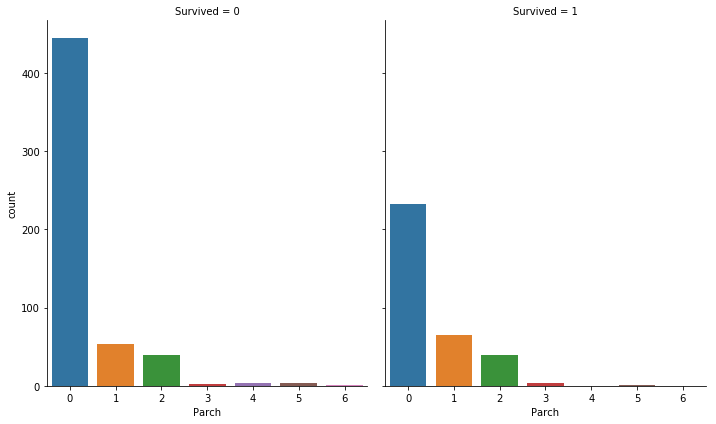

In [163]:
sns.catplot("Parch", col="Survived", col_wrap=4,
               data=data[data.Survived.notnull()],
                kind="count", height=6, aspect=.8)

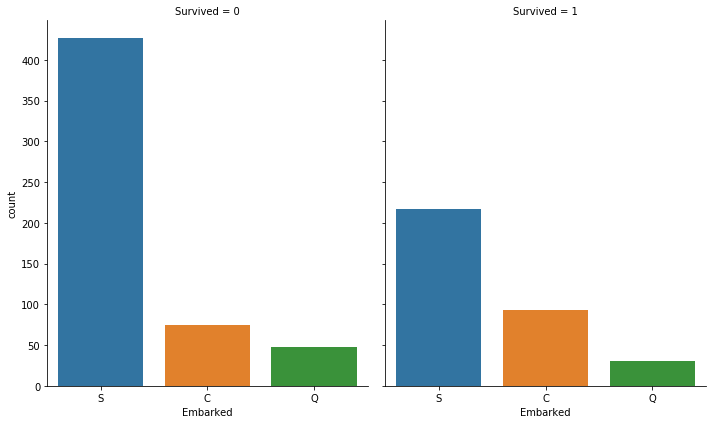

In [41]:
sns.catplot("Embarked", col="Survived", col_wrap=4,
               data=data[data.Survived.notnull() & (data.Embarked != 'nan') ],
                kind="count", height=6, aspect=.8)

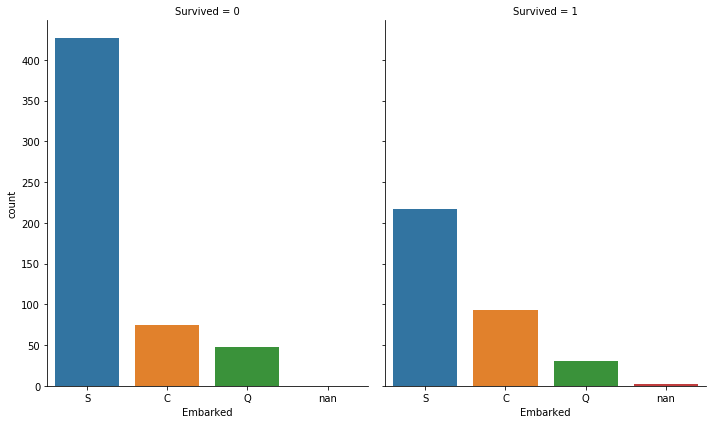

In [42]:
sns.catplot("Embarked", col="Survived", col_wrap=4,
               data=data[data.Survived.notnull()],
                kind="count", height=6, aspect=.8)

In [39]:
data.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C
3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,S


In [24]:
data.groupby(["Pclass",'Survived']).agg({
    "Sex" : "count"
}).reset_index().sort_values(["Pclass",'Survived']).rename(columns = {'Sex':"#Passenger"})

,Pclass,Survived,#Passenger
0,1,0,80
1,1,1,136
2,2,0,97
3,2,1,87
4,3,0,372
5,3,1,119


In [20]:
data.groupby(["Sex",'Survived']).agg({
    "Pclass" : "count"
}).reset_index().sort_values(["Sex",'Survived']).rename(columns = {'Pclass':"#Passenger"})

In [25]:
data.groupby(["SibSp","Survived"]).agg({
    "Sex" : "count"
}).reset_index().sort_values(["SibSp","Survived"]).rename(columns = {'Sex':"#Passenger"})

,SibSp,Survived,#Passenger
0,0,0,398
1,0,1,210
2,1,0,97
3,1,1,112
4,2,0,15
5,2,1,13
6,3,0,12
7,3,1,4
8,4,0,15
9,4,1,3


In [27]:
data.groupby(["Parch","Survived"]).agg({
    "Sex" : "count"
}).reset_index().sort_values(["Parch","Survived"]).rename(columns = {'Sex':"#Passenger"})

,Parch,Survived,#Passenger
0,0,0,445
1,0,1,233
2,1,0,53
3,1,1,65
4,2,0,40
5,2,1,40
6,3,0,2
7,3,1,3
8,4,0,4
9,5,0,4


In [28]:
data.groupby(["Embarked","Survived"]).agg({
    "Sex" : "count"
}).reset_index().sort_values(["Embarked","Survived"]).rename(columns = {'Sex':"#Passenger"})

,Embarked,Survived,#Passenger
0,C,0,75
1,C,1,93
2,Q,0,47
3,Q,1,30
4,S,0,427
5,S,1,217
6,nan,1,2


2.3 Kết luận

In [ ]:
Kết luận: 
1.Pclass càng cao thì khả năng sống sót càng thấp, cụ thể:
   - Pclass = 3, tỉ lệ sống sót / tử vong gần bằng 1/3, trong khi đó tỉ lệ này ngang nhau khi Pclass = 2 và khi Pclass =1
        thì tỉ lệ này tăng lên khoảng 3/2
2. Sex: Khả năng sống sót ở nữ giới cao hơn nam giới
3. SibSp: những người có SibSp = 1 hoặc 2 (có thể đi cùng anh em, vợ chồng) thì khả năng sống sót cao hơn những trường hợp còn lại, 
cụ thể:
    SibSp = 1 hoặc 2 thì tỉ lệ sống sót /  tử vong gần bằng 1, trong khi đó, tỉ lệ này ở những trường hợp còn lại đều thấp hơn 1.
        
4. Parch : Những người có Parch = 1, 2,3 (đi cùng ba mẹ, hoặc con cái) thì khả năng sống sót cao hơn các trường hợp còn lại
5. Embarked: Những người lên tàu từ Cherbourg có khả năng sống sót cao hơn những hành khách lên tàu từ các bến khác

# 3. Khảo sát chi tiết 2 chiều (giữa Survived với numerical)

In [ ]:
 Khảo sát hình thái tương quan giữa 2 biến
  (boxplot side by side - sort theo mean)

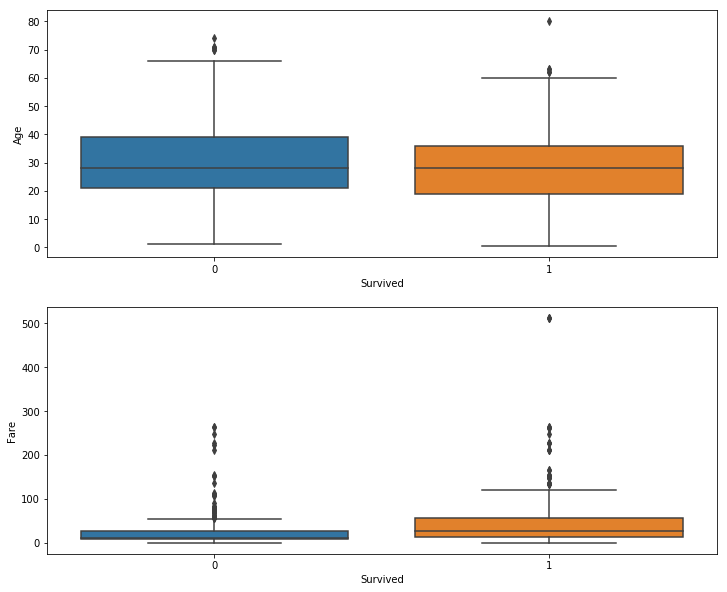

In [174]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
for var, subplot in zip(numerical, ax.flatten()):
    sns.boxplot(y=var, x='Survived', data=data, ax=subplot)

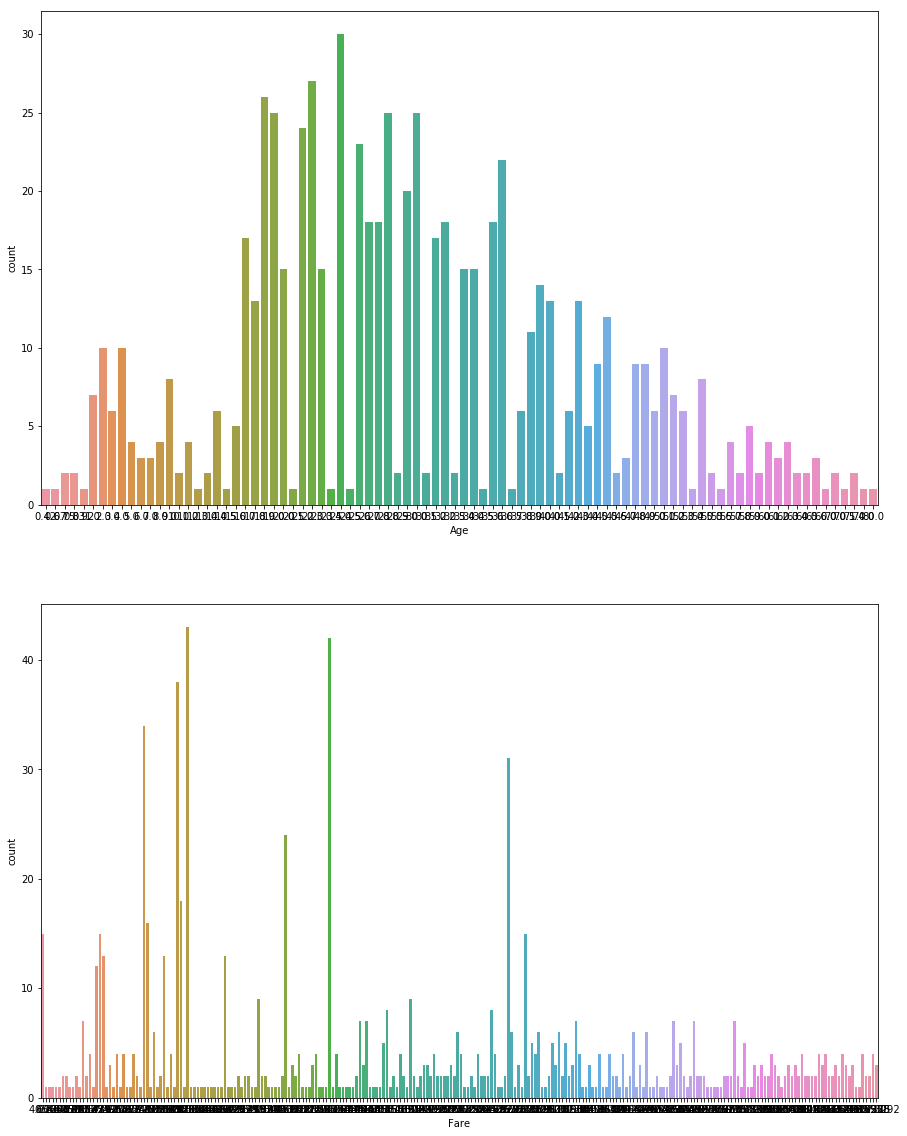

In [185]:
fig, ax = plt.subplots(2, 1, figsize=(15, 20))
for var, subplot in zip(numerical, ax.flatten()):
    sns.countplot(data[var], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

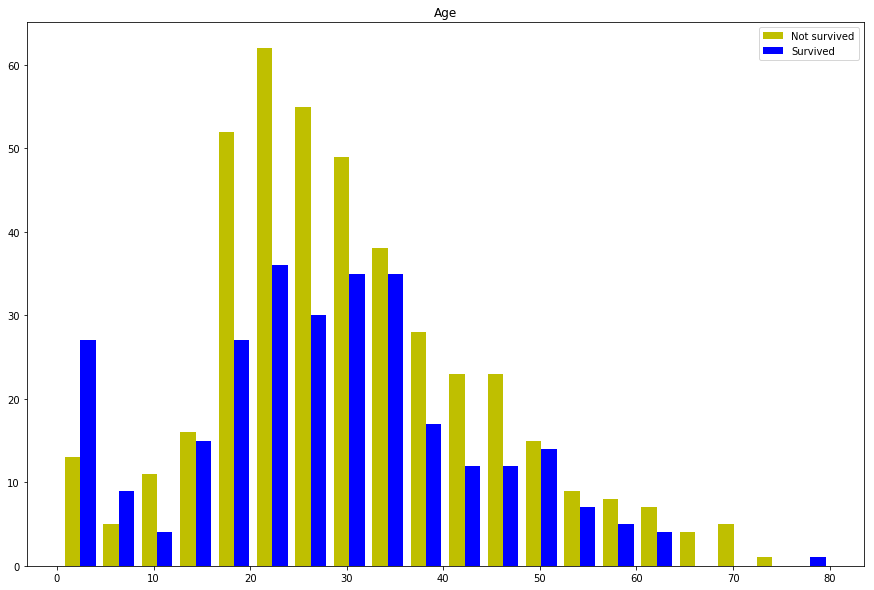

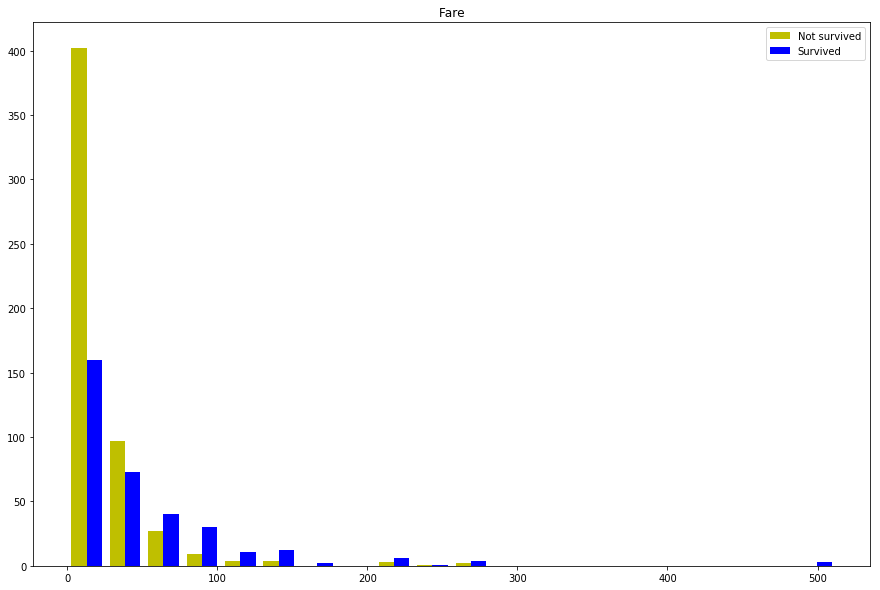

In [15]:
not_survived = data.loc[data["Survived"]== '0']
survived = data.loc[data["Survived"]== '1']
for column in ["Age", "Fare"]:
    plt.figure(figsize=(15, 10))
    not_survived_data = not_survived[column]
    survived_data = survived[column]
    plt.hist([not_survived_data, survived_data], bins=20, color=["y", "b"], label=["Not survived", "Survived"])
    plt.legend(loc="upper right")
    plt.title(column)
    plt.show()

In [ ]:
Kết luận:
    1. Khả năng sống sót của các hành khách từ 18 đến 48 tuổi là thấp nhất, trẻ em (dưới 10 tuổi) và người cao tuổi (>70 tuổi)
    là những đối tượng được ưu tiên cứu hộ thì có khả năng sống sót cao nhất.
    2. Đối với hành khách mua vé rẻ thì khả năng sống sót rất thấp, khi giá vá càng cao thì khả năng sống sót càng tăng lên.

# Processing

# 1. Clean Data

# Drop Columns
Tỉ lệ Missing của cột Cabin quá lớn(77.10%) nên ta có thể xóa cột này

In [102]:
data1 = data.copy()

In [103]:
data1.drop(columns = ['Cabin','Name','Ticket'], axis = 1, inplace = True)

In [104]:
data1.describe(include = 'all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891,891,891,714.00,891,891,891.00,891
unique,2,3,2,nan,7,7,nan,4
top,0,3,male,nan,0,0,nan,S
freq,549,491,577,nan,608,678,nan,644
mean,NaN,NaN,NaN,29.70,NaN,NaN,32.20,NaN
std,NaN,NaN,NaN,14.53,NaN,NaN,49.69,NaN
min,NaN,NaN,NaN,0.42,NaN,NaN,0.00,NaN
25%,NaN,NaN,NaN,20.12,NaN,NaN,7.91,NaN
50%,NaN,NaN,NaN,28.00,NaN,NaN,14.45,NaN
75%,NaN,NaN,NaN,38.00,NaN,NaN,31.00,NaN


# Missing Age value:
Tỉ lệ Missing của côt Age là 17%. Trong 177 hành khách thiếu dữ liệu Age thì có 125 hành khánh tử vong, chủ yếu (136) vé có Pclass = 3(hạng thấp nhất), 124 hành khách nam. Age có ý nghĩa khá quan trọng, do đó ta sẽ thay thế missing value bằng giá trị median.

In [105]:
age_mean = data1['Age'].mean()
data1.fillna(value = {'Age':age_mean}, inplace = True)

In [16]:
data1.describe(include = 'all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
count,891,891,891,891.00,891,891,891,891.00,891
unique,2,3,2,nan,7,7,681,nan,4
top,0,3,male,nan,0,0,347082,nan,S
freq,549,491,577,nan,608,678,7,nan,644
mean,NaN,NaN,NaN,29.70,NaN,NaN,NaN,32.20,NaN
std,NaN,NaN,NaN,13.00,NaN,NaN,NaN,49.69,NaN
min,NaN,NaN,NaN,0.42,NaN,NaN,NaN,0.00,NaN
25%,NaN,NaN,NaN,22.00,NaN,NaN,NaN,7.91,NaN
50%,NaN,NaN,NaN,29.70,NaN,NaN,NaN,14.45,NaN
75%,NaN,NaN,NaN,35.00,NaN,NaN,NaN,31.00,NaN


In [ ]:
Missing Embarked
Có 2 hành khách bị sai dữ liệu về Embarked (dữ liệu Embarked được ghi lại bằng giá trị 'nan').
Ta sẽ thay thế giá trị của Embarked của 2 hành khách này bằng giá trị mod (chính là S)

In [17]:
data1['Embarked'].unique()

array(['S', 'C', 'Q', 'nan'], dtype=object)

In [34]:
data.loc[data['Embarked'] != 'nan']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.46,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.86,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.07,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.13,NaN,S


In [106]:
embarked_mode = data1['Embarked'].mode()
data1['Embarked'] = np.where(data1['Embarked'] == 'nan', embarked_mode, data1['Embarked'])

In [75]:
data1.describe(include = 'all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891,891,891,891.00,891,891,891.00,891
unique,2,3,2,nan,7,7,nan,3
top,0,3,male,nan,0,0,nan,S
freq,549,491,577,nan,608,678,nan,646
mean,NaN,NaN,NaN,29.70,NaN,NaN,32.20,NaN
std,NaN,NaN,NaN,13.00,NaN,NaN,49.69,NaN
min,NaN,NaN,NaN,0.42,NaN,NaN,0.00,NaN
25%,NaN,NaN,NaN,22.00,NaN,NaN,7.91,NaN
50%,NaN,NaN,NaN,29.70,NaN,NaN,14.45,NaN
75%,NaN,NaN,NaN,35.00,NaN,NaN,31.00,NaN


# 1.2 Outlier

Fare Outlier: Replace with Max
    Từ Fare boxplot, có 116 dòng dữ liệu nằm ở vùng outlier (Giá vé > 66), trong đó
    có 3 dòng dữ liệu có giá vé cao đặc biệt(>500)
Age Outlier: Replace with Max
    Từ Age Boxplot, có 42 dòng dữ liệu nằm ngoài outlier (Age > 55 tuổi)

In [107]:
age_floor, age_ceiling = find_outliers_tukey(data1['Age'])
fare_floor, fare_ceiling = find_outliers_tukey(data1['Fare'])
print('Age floor: %s  ceiling: %s' %(age_floor, age_ceiling))
print('Fare floor: %s  ceiling: %s' %(fare_floor, fare_ceiling))

Age floor: 2.5  ceiling: 54.5
Fare floor: -26.724  ceiling: 65.6344


In [108]:
data1['Age'] = np.where(data1['Age'] > age_ceiling, age_ceiling, data1['Age'])
data1['Fare'] = np.where(data1['Fare'] > age_ceiling, fare_ceiling, data1['Fare'])

In [22]:
mask = data1['Age'] > age_ceiling
data1.loc[mask,'Age'].count()

0

In [23]:
mask = data1['Fare'] > fare_ceiling
data1.loc[mask]['Fare'].count()

0

In [109]:
data1.describe(include = 'all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891,891,891,891.00,891,891,891.00,891
unique,2,3,2,nan,7,7,nan,3
top,0,3,male,nan,0,0,nan,S
freq,549,491,577,nan,608,678,nan,646
mean,NaN,NaN,NaN,29.35,NaN,NaN,24.26,NaN
std,NaN,NaN,NaN,12.13,NaN,NaN,20.86,NaN
min,NaN,NaN,NaN,0.42,NaN,NaN,0.00,NaN
25%,NaN,NaN,NaN,22.00,NaN,NaN,7.91,NaN
50%,NaN,NaN,NaN,29.70,NaN,NaN,14.45,NaN
75%,NaN,NaN,NaN,35.00,NaN,NaN,31.00,NaN


# 3. Nomalize
(transform để đưa về gần chuẩn: giảm biên độ, đưa về hình chuông)

# Numerical Variables Age and Fare

In [168]:
normalize_data = data1.copy()

In [169]:
normalize_data.describe()

,Age,Fare
count,891.00,891.00
mean,29.35,24.26
std,12.13,20.86
min,0.42,0.00
25%,22.00,7.91
50%,29.70,14.45
75%,35.00,31.00
max,54.50,65.63


In [170]:
print("Skewness of Age: %f" % normalize_data['Age'].skew())
print("Kurtosis of Age: %f" % normalize_data['Age'].kurt())
print("Skewness of Fare: %f" % normalize_data['Fare'].skew())
print("Kurtosis of Fare: %f" % normalize_data['Fare'].kurt())

Skewness of Age: 0.047067
Kurtosis of Age: 0.175739
Skewness of Fare: 1.091355
Kurtosis of Fare: -0.253455


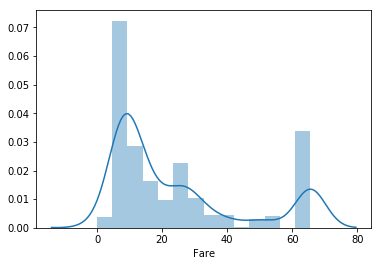

In [171]:
sns.distplot(normalize_data["Fare"])

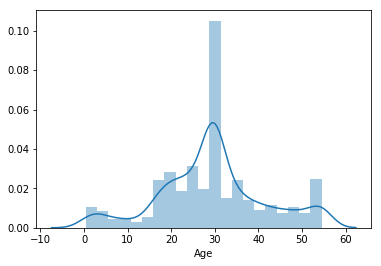

In [172]:
sns.distplot(normalize_data["Age"])

In [173]:
min_max_scaler = preprocessing.MinMaxScaler()
normalize_data["Age"] = min_max_scaler.fit_transform(normalize_data[["Age"]])
#normalize_data["Fare"] = min_max_scaler.fit_transform(normalize_data[["Fare"]])

In [174]:
normalize_data["Fare"] = np.log1p((normalize_data["Fare"]))

In [159]:
normalize_data.describe()

,Age,Fare
count,891.00,891.00
mean,3.29,2.90
std,0.61,0.84
min,0.35,0.00
25%,3.14,2.19
50%,3.42,2.74
75%,3.58,3.47
max,4.02,4.20


In [175]:
print("Skewness of Age: %f" % normalize_data['Age'].skew())
print("Kurtosis of Age: %f" % normalize_data['Age'].kurt())
print("Skewness of Fare: %f" % normalize_data['Fare'].skew())
print("Kurtosis of Fare: %f" % normalize_data['Fare'].kurt())

Skewness of Age: 0.047067
Kurtosis of Age: 0.175739
Skewness of Fare: -0.219615
Kurtosis of Fare: 0.637459


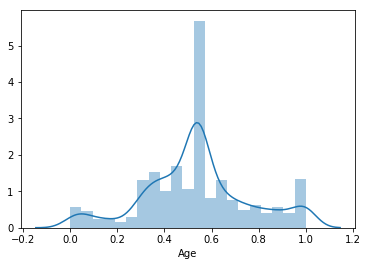

In [176]:
sns.distplot(normalize_data["Age"])

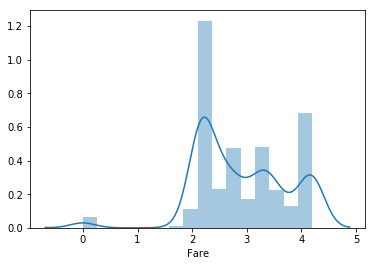

In [177]:
sns.distplot(normalize_data["Fare"])

# Categorical variables

In [119]:
categorical = ['Survived','Pclass', 'Sex','SibSp', 'Parch', 'Embarked']
numerical = ['Age',  'Fare']

In [149]:
data_pro = normalize_data.copy()
#Du lieu co thu tu chuyen ve so
#le = preprocessing.LabelEncoder()
#data_pro["Sex"] = le.fit_transform(data_pro["Sex"])

In [150]:
data_pro = pd.get_dummies(data_pro, columns=['Sex','Embarked'])

In [56]:
data_pro.head(3)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,0.40,1,0,0.11,0,1,0,0,1
2,1,1,0.69,1,0,1.00,1,0,1,0,0
3,1,3,0.47,0,0,0.12,1,0,0,0,1


# Modeling

In [151]:
Y = data_pro["Survived"]
X = data_pro.drop("Survived", axis = 1 )

In [152]:
x_train, x_test , y_train, y_test= train_test_split(X,Y,test_size=0.3,random_state = 12)

In [153]:
logmodel = LogisticRegression(max_iter = 300)
logmodel.fit(x_train,y_train)
predictions = logmodel.predict(x_test)

In [154]:
accuracy_score(y_test,predictions)

0.7873134328358209

In [155]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       161
           1       0.76      0.68      0.72       107

   micro avg       0.79      0.79      0.79       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.79      0.79      0.79       268



In [156]:
logmodel.coef_

array([[-0.70374596, -1.40817796, -0.3932735 , -0.05685038,  0.5097461 ,
         1.57557804, -1.07086494,  0.19608147,  0.29275186,  0.01587977]])